In [3]:
import os 
import glob 
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import shutil
from scipy.stats import linregress
import cartopy.io.shapereader as shpreader
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from shapely.prepared import prep
import regionmask
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import xesmf as xe
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
import matplotlib.cm as cm
import calendar
from collections import Counter
import itertools
import rasterio
import struct
from datetime import datetime, timedelta
from tqdm import tqdm
import subprocess
import urllib.request
import zipfile

# Set global font to a sans-serif type suitable for publishing
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use 'Helvetica' or 'DejaVu Sans' if Arial is unavailable
    'font.size': 8,               # Default font size
    'axes.titlesize': 8,          # Title font size
    'axes.labelsize': 8,          # X and Y labels font size
    'xtick.labelsize': 8,         # X-axis tick labels font size
    'ytick.labelsize': 8,         # Y-axis tick labels font size
    'legend.fontsize': 8,         # Legend font size
    'figure.titlesize': 8         # Figure title font size
})

ModuleNotFoundError: No module named 'cartopy'

# Change inputs

Files structure is .$home/PRISM/{var_name}/netdf

In [ ]:
# home = '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM'
home = '/home/sd96/rdf'
# home = '/home/sd96/wastewater'
# shapefile = os.path.join(home, 'harris_county.geojson')
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
# shapefile = "/home/ib28/mymount/sd75/isabelleb/wastewater/shapefiles/Regional_County_Boundaries.shp"

# Downloading BIL Files from PRISM 

    Saves zip files in rdf in folders `zip_ppt`, `zip_tmean`, `zip_tdmean`
    Saves unziped files in rdf folders `ppt`, `tmean`, `tdmean`

In [8]:
daily = "D2"
monthly = "M3"
clim_var = "tmean"
folder = os.path.join(home, f'zip_{clim_var}')
base_url = "https://services.nacse.org/prism/data/public/4km"
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

In [20]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import urllib.request
import os

def _progress_hook(block_num, block_size, total_size, t):
    """
    Callback function to update tqdm progress bar during file download.
    """
    downloaded = block_num * block_size
    if total_size > 0:
        t.update(min(block_size, total_size - t.n))
    else:
        t.update(downloaded - t.n)

vars = ['tmean', 'tdmean']

for clim_var in vars:
    folder = os.path.join(home, f'zip_{clim_var}')
    print("Downloading files for", clim_var, "in folder", os.path.join(folder))
    print(f"Using url {base_url}/{clim_var}/{month}")
    curr = start
    while curr <= stop:
        month = curr.strftime("%Y%m")
        url = f"{base_url}/{clim_var}/{month}"
        output_file = os.path.join(folder, month)
        
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=f'Downloading {month}') as t:
            urllib.request.urlretrieve(
                url,
                output_file,
                reporthook=lambda block_num, block_size, total_size: _progress_hook(block_num, block_size, total_size, t)
            )

        curr += relativedelta(months=1)

Using url https://services.nacse.org/prism/data/public/4km/tmean/202412


Using url https://services.nacse.org/prism/data/public/4km/tdmean/202412


In [21]:
vars = ['tmean', 'tdmean']
for clim_var in vars:
    
    unzip_folder = os.path.join(home, clim_var)
    print(f"Unzipping {clim_var} files in {unzip_folder}")
    folder = os.path.join(home, f'zip_{clim_var}')
    print("Using folder", folder)
    print(start)
    
    curr = start
    while curr <= stop:
        month = curr.strftime("%Y%m")
        zip_file_path = os.path.join(folder, month)

        # Check if the ZIP file exists
        if os.path.exists(zip_file_path):
            # Unzip the file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(unzip_folder)
                print(f"UNZIP file for {month} is completed.")
        else:
            print(f"ZIP file for {month} not found.")

        curr += relativedelta(months=1)

Unzipping tmean files in /home/sd96/rdf/tmean
Using folder /home/sd96/rdf/zip_tmean
2020-01-01 00:00:00
UNZIP file for 202001 is completed.
UNZIP file for 202002 is completed.
UNZIP file for 202003 is completed.
UNZIP file for 202004 is completed.
UNZIP file for 202005 is completed.
UNZIP file for 202006 is completed.
UNZIP file for 202007 is completed.
UNZIP file for 202008 is completed.
UNZIP file for 202009 is completed.
UNZIP file for 202010 is completed.
UNZIP file for 202011 is completed.
UNZIP file for 202012 is completed.
UNZIP file for 202101 is completed.
UNZIP file for 202102 is completed.
UNZIP file for 202103 is completed.
UNZIP file for 202104 is completed.
UNZIP file for 202105 is completed.
UNZIP file for 202106 is completed.
UNZIP file for 202107 is completed.
UNZIP file for 202108 is completed.
UNZIP file for 202109 is completed.
UNZIP file for 202110 is completed.
UNZIP file for 202111 is completed.
UNZIP file for 202112 is completed.
UNZIP file for 202201 is complet

In [25]:
def parse_header(hdr_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def read_bil_manual(bil_path, hdr_path):
    """
    Reads a .bil file manually using information from its .hdr file.
    """
    header = parse_header(hdr_path)

    nrows = int(header.get('NROWS', 0))
    ncols = int(header.get('NCOLS', 0))
    nbits = int(header.get('NBITS', 0))
    byteorder = header.get('BYTEORDER', 'I') # 'I' for Intel (little-endian), 'M' for Motorola (big-endian)
    pixeltype = header.get('PIXELTYPE', 'SIGNEDINT') # Example: FLOAT, SIGNEDINT, UNSIGNEDINT

    # Determine data type for struct and numpy
    if nbits == 8:
        dtype = np.int8 if pixeltype == 'SIGNEDINT' else np.uint8
        fmt_char = 'b' if pixeltype == 'SIGNEDINT' else 'B'
    elif nbits == 16:
        dtype = np.int16 if pixeltype == 'SIGNEDINT' else np.uint16
        fmt_char = 'h' if pixeltype == 'SIGNEDINT' else 'H'
    elif nbits == 32:
        if pixeltype == 'FLOAT':
            dtype = np.float32
            fmt_char = 'f'
        else:
            dtype = np.int32 if pixeltype == 'SIGNEDINT' else np.uint32
            fmt_char = 'i' if pixeltype == 'SIGNEDINT' else 'I'
    else:
        raise ValueError(f"Unsupported NBITS: {nbits}")

    endian_prefix = '<' if byteorder == 'I' else '>' # Little-endian or Big-endian

    with open(bil_path, 'rb') as f:
        bil_data = f.read()

    # Unpack binary data
    num_elements = nrows * ncols
    format_string = f"{endian_prefix}{num_elements}{fmt_char}"
    unpacked_data = struct.unpack(format_string, bil_data)

    # Reshape into a 2D array
    data_array = np.array(unpacked_data, dtype=dtype).reshape(nrows, ncols)

    return data_array

# Example usage:
bil_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.bil') 
hdr_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.hdr') 
bil_data_manual = read_bil_manual(bil_file, hdr_file)

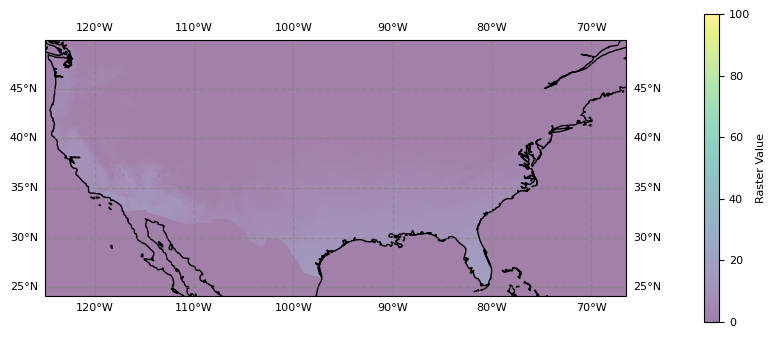

In [28]:
# Read raster data from .bil file
bil_file_path = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.bil') 

# Use rasterio to read the raster data
with rasterio.open(bil_file_path) as src:
    raster_data = src.read(1)
    transform = src.transform

# Visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the desired minimum and maximum values for the colormap
vmin = 0  
vmax = 100  

# Plot the raster data using imshow with vmin and vmax
im = ax.imshow(raster_data, extent=(transform[2], transform[2] + transform[0] * raster_data.shape[1],
                                    transform[5] + transform[4] * raster_data.shape[0], transform[5]),
               origin='upper', cmap='viridis', alpha=0.5, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.4)
cbar.set_label('Raster Value')

# Add gridlines and coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.show()

In [30]:
# Convert the data into an xarray dataset 

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

header_data = parse_header(hdr_file)
x0 = float(header_data['ULXMAP'])
y0 = float(header_data['ULYMAP'])
dx = float(header_data['XDIM'])
dy = float(header_data['YDIM'])
    
Nx = raster_data.shape[1]
Ny = raster_data.shape[0]
# dx = transform[0]
# dy = transform[4]
# x0 = transform[2]
# y0 = transform[5] 
    
longitude = create_array_with_step(Nx, x0, dx)
latitude = create_array_with_step(Ny, y0, -dy) 
filename_parts = bil_file_path.split('.')[0].split('_') 

# Daily 
timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 

# Monthly 
# timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
var_data = np.expand_dims(raster_data, axis=2)

In [31]:
ds = xr.Dataset(
    data_vars=dict(
        tmean=(('lat', 'lon', 'time'), var_data),
    ),
    coords=dict(
        lon=('lon', longitude),
        lat=('lat', latitude),
        time=('time', timestamp), 
    ),
    attrs=dict(description="PRISM data"),
)

<GeoAxes: title={'center': 'time = 2021-01-01'}, xlabel='lon', ylabel='lat'>

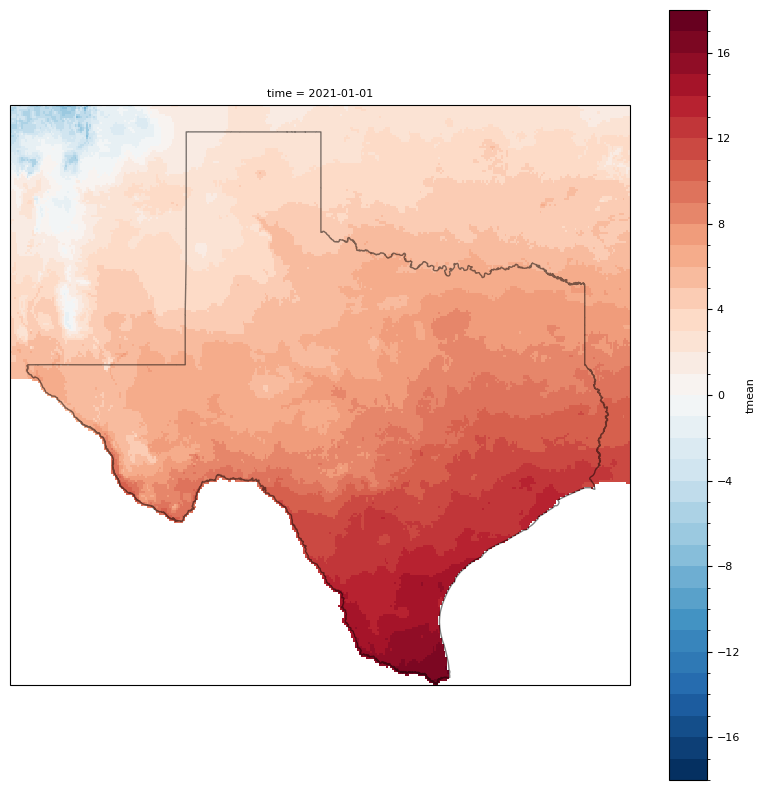

In [35]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-10, 31, 1) 
ds = ds.sortby('lat') 
ds_plot = ds.sel(lat = slice(25, 37), lon = slice(-107, -93)) 
ds_plot = ds_plot.where(ds_plot.tmean > -8000, drop = True) 
levels = np.arange(-18, 19, 1)
ds_plot.sel(time = '20210101').tmean.plot(x = 'lon', y = 'lat', ax = ax, levels = levels)

shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
states = gpd.read_file(shapefile)

##### Filter for Texas #####
texas = states[states['NAME'] == 'Texas']

##### Plot Texas Boundary #####
texas.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=1)

# Read all datasets into NetCDF format

In [11]:
def parse_header(hdr_file_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def parse_bil(bil_file_path): 
    # Use rasterio to read the raster data
    with rasterio.open(bil_file_path) as src:
        raster_data = src.read(1)
    return raster_data       

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

In [12]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2020', '2021', '2022', '2023', '2024']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for var in variables:
    
    homedir = f'{var}'
    
    outdir = os.path.join(home, homedir, 'netcdf') 
    print(f"Saving files in {outdir}")
    if os.path.exists(outdir) == False: 
        os.mkdir(outdir) 
    for year in years: 
        for m in months: 
            bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.bil') 
            hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.hdr') 
    
            outfile = os.path.join(home, outdir, f'PRISM_{var}_stable_4kmM3_{year}{m}.nc')
    
            # Read in raster data 
            raster_data = parse_bil(bil_file) 
            Nx = raster_data.shape[1]
            Ny = raster_data.shape[0]
    
            # Read in header data 
            hdr_data = parse_header(hdr_file) 
            x0 = float(hdr_data['ULXMAP'])
            y0 = float(hdr_data['ULYMAP'])
            dx = float(hdr_data['XDIM'])
            dy = float(hdr_data['YDIM'])
    
            # Create coordinate arrays for dataset 
            longitude = create_array_with_step(Nx, x0, dx)
            latitude = create_array_with_step(Ny, y0, -dy) 
            filename_parts = bil_file.split('.')[0].split('_') 
            timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
            var_data = np.expand_dims(raster_data, axis=2)
    
            # Create dataset 
            ds = xr.Dataset(
                data_vars=dict(
                    tmp=(('lat', 'lon', 'time'), var_data),
                ),
                coords=dict(
                    lon=('lon', longitude),
                    lat=('lat', latitude),
                    time=('time', timestamp), 
                ),
                attrs=dict(description=f"PRISM {var} data"),
            )
            ds = ds.rename({'tmp':var})
    
            # Save dataset 
            ds.to_netcdf(outfile) 
            print("Saved", outfile)
            ds.close()

Saving files in /home/sd96/rdf/ppt/netcdf
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202001.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202002.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202003.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202004.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202005.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202006.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202007.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202008.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202009.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202010.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202011.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202012.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202101.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable_4kmM3_202102.nc
Saved /home/sd96/rdf/ppt/netcdf/PRISM_ppt_stable

In [33]:
##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties_shapefile = gpd.read_file(counties_shapefile_path)

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

# ##### Filter for HC #####
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

print(HC.geometry.bounds)
print(HC.geometry.crs) 

           minx       miny       maxx       maxy
1318 -95.960733  29.497297 -94.908492  30.170606
EPSG:4269


# Get values in Harris County 

In [13]:
##### -------- Get KG Classes for Texas -------- #####

##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
# counties = gpd.read_file(shapefile)
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(counties_shapefile_path)

# ##### Filter for HC #####
# HC = counties[counties.NAME == 'Harris']
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

##### Read in files #####
variables = ['tmean', 'tdmean', 'ppt'] 
for var in variables: 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    
    print(f"sorting file in directory {homedir}")
    
    # Get all the monthly files 
    files = glob.glob(os.path.join(home, homedir, 'PRISM*M3*.nc'))
    files.sort() 

#     for f in files: 
    for f in tqdm(files, desc=f"Processing {var}", unit="file"):

        filename = f.split('/')[-1].split('.')[0]
        print(filename)
        outfile = os.path.join(home, homedir, f'Harris_County_{filename}.nc') 
        
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        with xr.open_dataset(f) as ds: 

            # Limit file 
            ds = ds.sortby('lat') 
            ds = ds.sel(lon = slice(-96.5, -94.5), lat = slice(29.1, 30.5))
            
            # Get the lat/lon coordinates
            lats = ds['lat'].values
            lons = ds['lon'].values
    
            # Create a 2D mesh of coordinates
            lon2d, lat2d = np.meshgrid(lons, lats)
    
            # Flatten the mesh for easier masking
            points = np.array([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())])
    
            # Check which points fall inside the HC polygon
            within_HC = np.array([HC.geometry.iloc[0].contains(p) for p in points])
            mask = within_HC.reshape(lat2d.shape)
    
            # Apply mask to data
            # If 3D (time, lat, lon)
            if "time" in ds.dims:
                mask = np.expand_dims(mask, axis=2)
                masked = ds.where(mask)
            else:
                # 2D (lat, lon)
                masked = ds.where(mask)
            
            # Save data 
            valid_points = masked[var].count().values
            # print(f"\tValid points in {var}: {valid_points}")

            print(f"\tSaved ({valid_points}): {outfile}")
            masked.to_netcdf(outfile) 

sorting file in directory /home/sd96/rdf/ppt/netcdf


Processing ppt:   0%|                                  | 0/60 [00:00<?, ?file/s]

PRISM_ppt_stable_4kmM3_202001


Processing ppt:   2%|▍                         | 1/60 [00:00<00:31,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202001.nc
PRISM_ppt_stable_4kmM3_202002


Processing ppt:   3%|▊                         | 2/60 [00:01<00:31,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202002.nc
PRISM_ppt_stable_4kmM3_202003


Processing ppt:   5%|█▎                        | 3/60 [00:01<00:31,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202003.nc
PRISM_ppt_stable_4kmM3_202004


Processing ppt:   7%|█▋                        | 4/60 [00:02<00:31,  1.80file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202004.nc
PRISM_ppt_stable_4kmM3_202005


Processing ppt:   8%|██▏                       | 5/60 [00:02<00:30,  1.81file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202005.nc
PRISM_ppt_stable_4kmM3_202006


Processing ppt:  10%|██▌                       | 6/60 [00:03<00:29,  1.81file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202006.nc
PRISM_ppt_stable_4kmM3_202007


Processing ppt:  12%|███                       | 7/60 [00:03<00:29,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202007.nc
PRISM_ppt_stable_4kmM3_202008


Processing ppt:  13%|███▍                      | 8/60 [00:04<00:28,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202008.nc
PRISM_ppt_stable_4kmM3_202009


Processing ppt:  15%|███▉                      | 9/60 [00:04<00:27,  1.82file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202009.nc
PRISM_ppt_stable_4kmM3_202010


Processing ppt:  17%|████▏                    | 10/60 [00:05<00:27,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202010.nc
PRISM_ppt_stable_4kmM3_202011


Processing ppt:  18%|████▌                    | 11/60 [00:06<00:26,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202011.nc
PRISM_ppt_stable_4kmM3_202012


Processing ppt:  20%|█████                    | 12/60 [00:06<00:26,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202012.nc
PRISM_ppt_stable_4kmM3_202101


Processing ppt:  22%|█████▍                   | 13/60 [00:07<00:25,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202101.nc
PRISM_ppt_stable_4kmM3_202102


Processing ppt:  23%|█████▊                   | 14/60 [00:07<00:25,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202102.nc
PRISM_ppt_stable_4kmM3_202103


Processing ppt:  25%|██████▎                  | 15/60 [00:08<00:24,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202103.nc
PRISM_ppt_stable_4kmM3_202104


Processing ppt:  27%|██████▋                  | 16/60 [00:08<00:23,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202104.nc
PRISM_ppt_stable_4kmM3_202105


Processing ppt:  28%|███████                  | 17/60 [00:09<00:23,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202105.nc
PRISM_ppt_stable_4kmM3_202106


Processing ppt:  30%|███████▌                 | 18/60 [00:09<00:22,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202106.nc
PRISM_ppt_stable_4kmM3_202107


Processing ppt:  32%|███████▉                 | 19/60 [00:10<00:22,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202107.nc
PRISM_ppt_stable_4kmM3_202108


Processing ppt:  33%|████████▎                | 20/60 [00:10<00:21,  1.88file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202108.nc
PRISM_ppt_stable_4kmM3_202109


Processing ppt:  35%|████████▊                | 21/60 [00:11<00:20,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202109.nc
PRISM_ppt_stable_4kmM3_202110


Processing ppt:  37%|█████████▏               | 22/60 [00:11<00:20,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202110.nc
PRISM_ppt_stable_4kmM3_202111


Processing ppt:  38%|█████████▌               | 23/60 [00:12<00:19,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202111.nc
PRISM_ppt_stable_4kmM3_202112


Processing ppt:  40%|██████████               | 24/60 [00:13<00:19,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202112.nc
PRISM_ppt_stable_4kmM3_202201


Processing ppt:  42%|██████████▍              | 25/60 [00:13<00:18,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202201.nc
PRISM_ppt_stable_4kmM3_202202


Processing ppt:  43%|██████████▊              | 26/60 [00:14<00:18,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202202.nc
PRISM_ppt_stable_4kmM3_202203


Processing ppt:  45%|███████████▎             | 27/60 [00:14<00:17,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202203.nc
PRISM_ppt_stable_4kmM3_202204


Processing ppt:  47%|███████████▋             | 28/60 [00:15<00:17,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202204.nc
PRISM_ppt_stable_4kmM3_202205


Processing ppt:  48%|████████████             | 29/60 [00:15<00:16,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202205.nc
PRISM_ppt_stable_4kmM3_202206


Processing ppt:  50%|████████████▌            | 30/60 [00:16<00:16,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202206.nc
PRISM_ppt_stable_4kmM3_202207


Processing ppt:  52%|████████████▉            | 31/60 [00:16<00:15,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202207.nc
PRISM_ppt_stable_4kmM3_202208


Processing ppt:  53%|█████████████▎           | 32/60 [00:17<00:15,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202208.nc
PRISM_ppt_stable_4kmM3_202209


Processing ppt:  55%|█████████████▊           | 33/60 [00:17<00:14,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202209.nc
PRISM_ppt_stable_4kmM3_202210


Processing ppt:  57%|██████████████▏          | 34/60 [00:18<00:14,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202210.nc
PRISM_ppt_stable_4kmM3_202211


Processing ppt:  58%|██████████████▌          | 35/60 [00:18<00:13,  1.84file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202211.nc
PRISM_ppt_stable_4kmM3_202212


Processing ppt:  60%|███████████████          | 36/60 [00:19<00:12,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202212.nc
PRISM_ppt_stable_4kmM3_202301


Processing ppt:  62%|███████████████▍         | 37/60 [00:20<00:12,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202301.nc
PRISM_ppt_stable_4kmM3_202302


Processing ppt:  63%|███████████████▊         | 38/60 [00:20<00:11,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202302.nc
PRISM_ppt_stable_4kmM3_202303


Processing ppt:  65%|████████████████▎        | 39/60 [00:21<00:11,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202303.nc
PRISM_ppt_stable_4kmM3_202304


Processing ppt:  67%|████████████████▋        | 40/60 [00:21<00:10,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202304.nc
PRISM_ppt_stable_4kmM3_202305


Processing ppt:  68%|█████████████████        | 41/60 [00:22<00:10,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202305.nc
PRISM_ppt_stable_4kmM3_202306


Processing ppt:  70%|█████████████████▌       | 42/60 [00:22<00:09,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202306.nc
PRISM_ppt_stable_4kmM3_202307


Processing ppt:  72%|█████████████████▉       | 43/60 [00:23<00:09,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202307.nc
PRISM_ppt_stable_4kmM3_202308


Processing ppt:  73%|██████████████████▎      | 44/60 [00:23<00:08,  1.89file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202308.nc
PRISM_ppt_stable_4kmM3_202309


Processing ppt:  75%|██████████████████▊      | 45/60 [00:24<00:08,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202309.nc
PRISM_ppt_stable_4kmM3_202310


Processing ppt:  77%|███████████████████▏     | 46/60 [00:24<00:07,  1.82file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202310.nc
PRISM_ppt_stable_4kmM3_202311


Processing ppt:  78%|███████████████████▌     | 47/60 [00:25<00:07,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202311.nc
PRISM_ppt_stable_4kmM3_202312


Processing ppt:  80%|████████████████████     | 48/60 [00:25<00:06,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202312.nc
PRISM_ppt_stable_4kmM3_202401


Processing ppt:  82%|████████████████████▍    | 49/60 [00:26<00:05,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202401.nc
PRISM_ppt_stable_4kmM3_202402


Processing ppt:  83%|████████████████████▊    | 50/60 [00:27<00:05,  1.88file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202402.nc
PRISM_ppt_stable_4kmM3_202403


Processing ppt:  85%|█████████████████████▎   | 51/60 [00:27<00:04,  1.89file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202403.nc
PRISM_ppt_stable_4kmM3_202404


Processing ppt:  87%|█████████████████████▋   | 52/60 [00:28<00:04,  1.90file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202404.nc
PRISM_ppt_stable_4kmM3_202405


Processing ppt:  88%|██████████████████████   | 53/60 [00:28<00:03,  1.88file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202405.nc
PRISM_ppt_stable_4kmM3_202406


Processing ppt:  90%|██████████████████████▌  | 54/60 [00:29<00:03,  1.89file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202406.nc
PRISM_ppt_stable_4kmM3_202407


Processing ppt:  92%|██████████████████████▉  | 55/60 [00:29<00:02,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202407.nc
PRISM_ppt_stable_4kmM3_202408


Processing ppt:  93%|███████████████████████▎ | 56/60 [00:30<00:02,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202408.nc
PRISM_ppt_stable_4kmM3_202409


Processing ppt:  95%|███████████████████████▊ | 57/60 [00:30<00:01,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202409.nc
PRISM_ppt_stable_4kmM3_202410


Processing ppt:  97%|████████████████████████▏| 58/60 [00:31<00:01,  1.86file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202410.nc
PRISM_ppt_stable_4kmM3_202411


Processing ppt:  98%|████████████████████████▌| 59/60 [00:31<00:00,  1.87file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202411.nc
PRISM_ppt_stable_4kmM3_202412


Processing ppt: 100%|█████████████████████████| 60/60 [00:32<00:00,  1.85file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202412.nc


infile /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202101.nc
371


Text(0.5, 0.77, '2021-01 Mean Monthly ppt in Harris County')

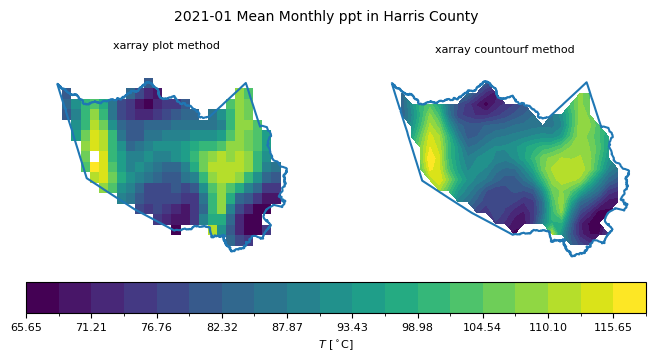

In [16]:
# Plot the Harris County data for 202101 to check 
HC_bounds = [-96.1, -94.8, 29.45, 30.25]

var = 'ppt'
date = '202101'
year = date[:4]
mon = date[4:]
datestr = pd.to_datetime(date, format="%Y%m")

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (8, 5))

# ax.set_xlim(HC_bounds[0], HC_bounds[1]) 
# ax.set_ylim(HC_bounds[2], HC_bounds[3]) 

# Plot tmean 
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{monthly}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 
ds = ds.sel(time = datestr, lon = slice(HC_bounds[0], HC_bounds[1]), lat = slice(HC_bounds[2], HC_bounds[3]))
vmin = float(ds[var].min())
vmax = float(ds[var].max())
levels = np.linspace(vmin, vmax, 20)
# levels = np.arange(11, 13.6, 0.1) 
CS = ds[var].plot(x = 'lon', y = 'lat', ax = ax[0], add_colorbar = False, levels = levels) 
CS = ds[var].plot.contourf(x = 'lon', y = 'lat', ax = ax[1], add_colorbar = False, levels = levels) 
ax[0].set_title('xarray plot method') 
ax[1].set_title('xarray countourf method') 

print(np.isnan(ds[var].values).sum())  # Count NaNs

# Plot HC boundary 
for i in range(2): 
    counties = gpd.read_file(shapefile)
    HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]
    HC.boundary.plot(ax = ax[i]) 
    
    # Plot Characteristics 
    ax[i].axis('off') 
plt.colorbar(CS, ax = ax, orientation = 'horizontal', pad = 0.04, label = r'$T$ [$^\circ$C]') 
plt.suptitle(f'{year}-{mon} Mean Monthly {var} in Harris County', y=0.77, fontsize = 10) 

# Time series of variables averaged over Harris County 

In [6]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [17]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
for var in variables: 
    for year in years: 
        homedir = os.path.join(home, f'{var}', 'netcdf') 
        files = glob.glob(os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}*.nc'))
        files.sort() 
    
        print(year, "# of files", len(files))
        ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').load() 
    
        outfile = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}.nc')
 
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        ds.to_netcdf(outfile) 
        print("Created: ", outfile)

2020 # of files 12
Created:  /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2020.nc
2021 # of files 12
Created:  /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2021.nc
2022 # of files 12
Created:  /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2022.nc
2023 # of files 12
Created:  /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2023.nc
2024 # of files 12
Created:  /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2024.nc


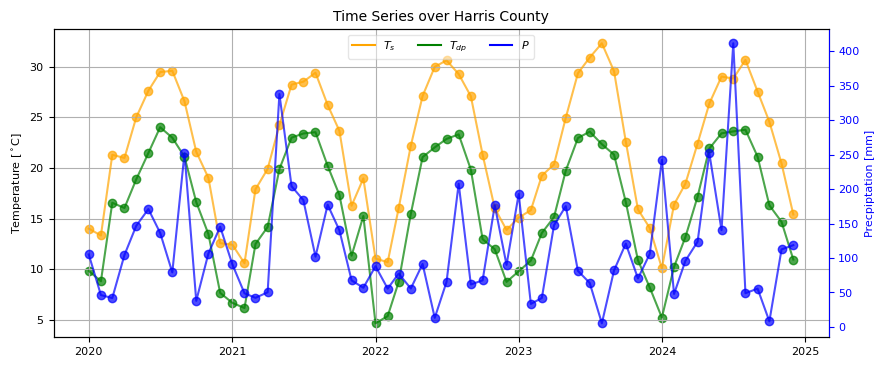

In [40]:
variables = ['tmean', 'tdmean', 'ppt'] 
colors = ['orange', 'green', 'blue'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 

for i, var in enumerate(variables): 
    color = colors[i]
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    
    if var == 'ppt': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(color)
        twin1.tick_params(axis='x', colors=color)
        twin1.tick_params(axis='y', colors=color)
        twin1.set_ylabel('Precpiptation [mm]', color = color) 
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=color, alpha = 0.7) 
    ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=color, alpha = 0.7) 
        
# Add a legend manually if needed
labels = ['$T_{s}$', r'$T_{dp}$', r'$P$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10) 
twin1.set_ylabel('Precpiptation [mm]', color = color)
plt.savefig('plots/monthly_tmean_tdmean_ppt')

# Back Calculate Relative Humidity

In [22]:
def rel_humidity(tas, tdp): 
    ''' 
    Calculates relative humidty (%) using the Mangus approximation 

    Inputs:
    tas - surface temperature (C)
    tdp - dew point temperature (C)

    Outputs:
    hurs - surface relative humidity (%)
    '''
    # Constants
    c1 = 17.625
    c2 = 243.04
    
    print(tdp.shape)
    print(tas.shape)
    # Mangus Forumla
    hurs = 100*(np.exp((c1*tdp)/(c2+tdp))/np.exp((c1*tas)/(c2+tas)))

    return hurs 


def rel_humidity_safe(tas, tdp):
    """
    Calculate relative humidity avoiding coordinate alignment issues
    """
    c1 = 17.625
    c2 = 243.04
    
    print('Input tas shape:', tas.shape)
    print('Input tdp shape:', tdp.shape)
    
    # Work directly with values to avoid coordinate issues
    numerator_vals = np.exp((c1 * tdp.values) / (c2 + tdp.values))
    denominator_vals = np.exp((c1 * tas.values) / (c2 + tas.values))
    
    hurs_vals = 100 * (numerator_vals / denominator_vals)
    
    print('Calculated hurs_vals shape:', hurs_vals.shape)
    
    # Create new DataArray using coordinates from tas (or tdp - they should be the same)
    hurs = xr.DataArray(
        hurs_vals,
        coords={
            'lat': tas.lat,
            'lon': tas.lon, 
            'time': tas.time
        },
        dims=['lat', 'lon', 'time'],
        name='hurs',
        attrs={'units': '%', 'long_name': 'Surface Relative Humidity'}
    )
    
    print('Final hurs shape:', hurs.shape)
    return hurs



In [25]:
outdir = os.path.join(home, 'hurs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{monthly}_{year}.nc'))
    files_tmean.sort() 
    files_tdmean = glob.glob(os.path.join(home, 'tdmean', 'netcdf', f'Harris_County_PRISM_tdmean_stable_4km{monthly}_{year}.nc'))
    files_tdmean.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_tdmean = xr.open_mfdataset(files_tdmean, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(outdir, f'Harris_County_PRISM_hurs_stable_4km{monthly}_{year}.nc')

    # Calculate relhum: 
    ds_hurs = rel_humidity_safe(ds_tmean.tmean, ds_tdmean.tdmean)

    # Save as netcdf 
    ds_hurs = ds_hurs.to_dataset(name = 'hurs')
    ds_hurs.to_netcdf(outfile)
    

Input tas shape: (34, 48, 12)
Input tdp shape: (34, 48, 12)
Calculated hurs_vals shape: (34, 48, 12)
Final hurs shape: (34, 48, 12)
Input tas shape: (34, 48, 12)
Input tdp shape: (34, 48, 12)
Calculated hurs_vals shape: (34, 48, 12)
Final hurs shape: (34, 48, 12)
Input tas shape: (34, 48, 12)
Input tdp shape: (34, 48, 12)
Calculated hurs_vals shape: (34, 48, 12)
Final hurs shape: (34, 48, 12)
Input tas shape: (34, 48, 12)
Input tdp shape: (34, 48, 12)
Calculated hurs_vals shape: (34, 48, 12)
Final hurs shape: (34, 48, 12)
Input tas shape: (34, 48, 12)
Input tdp shape: (34, 48, 12)
Calculated hurs_vals shape: (34, 48, 12)
Final hurs shape: (34, 48, 12)


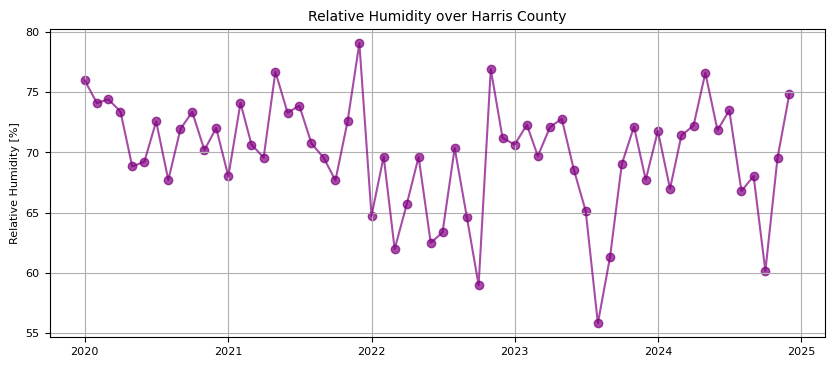

In [39]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
var = 'hurs'

homedir = os.path.join(home, f'{var}', 'netcdf') 
files = []
for year in years: 
    files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}.nc')) 

ds = xr.open_mfdataset(files, concat_dim='time', combine='nested', engine='netcdf4')

# ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

# Get mean 
ds_mean = weighted_mean(ds, 'lat', 'lon')

# Plot 
ds_mean[var].plot(x = 'time', ax = ax, color='purple', alpha = 0.7, label = r'$r$') 
ds_mean[var].plot.scatter(x = 'time', ax = ax, color='purple', alpha = 0.7) 


# ax.legend(loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Relative Humidity [%]') 
ax.grid() 
ax.set_title('Relative Humidity over Harris County', fontsize = 10) 
plt.savefig('plots/monthly_ts_hurs')

# Calculate wet bulb temperature 

In [28]:
def stull_wet_bulb_temp(tas, hurs):
    '''
    Calculates the approximation for wet bulb temperature developed by Stull et al (2011)

    Inputs:
    tas - surface temperature (C)
    hurs - relative humidity (%)

    Outputs:
    twbs - wet bulb temperature (C)
    '''

    # Constants
    c1 = 0.151977
    c2 = 8.313659
    c3 = 1.676331
    c4 = 0.00391838
    c5 = 0.023101
    c6 = 4.686035

    # Calculate wet bulb temperature
    twbs = tas * np.arctan(c1 * (hurs + c2)**(0.5)) + np.arctan(tas + hurs) - np.arctan(hurs - c3) + c4 * (hurs)**(1.5) * np.arctan(c5 * hurs) - c6

    return twbs


In [32]:
# outdir = 'twbs'
outdir = os.path.join(home, 'twbs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir)     

print(outdir)

for year in years: 
#     print(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{monthly}_{year}.nc'))
    print("Looking for:", os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{monthly}_{year}.nc'))

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{monthly}_{year}.nc'))
    
    files_tmean.sort() 
    files_hurs = glob.glob(os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{monthly}_{year}.nc'))
    files_hurs.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_hurs = xr.open_mfdataset(files_hurs, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_County_PRISM_twbs_stable_4km{monthly}_{year}.nc')

    # Calculate relhum: 
    ds_twbs = stull_wet_bulb_temp(ds_tmean.tmean, ds_hurs.hurs)

    # Save as netcdf 
    ds_twbs = ds_twbs.to_dataset(name = 'twbs')
    ds_twbs.to_netcdf(outfile)
    print("Created :", outfile)
    

/home/sd96/rdf/twbs/netcdf
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmM3_2020.nc
Created : /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmM3_2020.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmM3_2021.nc
Created : /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmM3_2021.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmM3_2022.nc
Created : /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmM3_2022.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmM3_2023.nc
Created : /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmM3_2023.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmM3_2024.nc
Created : /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmM3_2024.nc


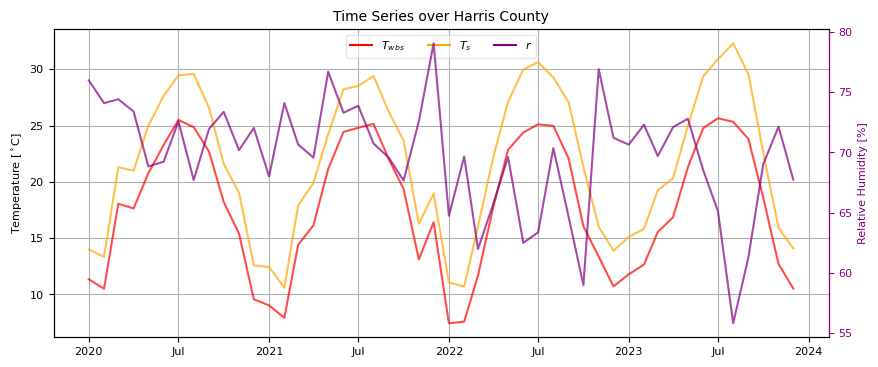

In [38]:
years = ['2020', '2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']

for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")

    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue

    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.7) 
#     ds_mean[var].plot.scatter(x='time', ax=axplot, color=colors[i], alpha=0.7)


labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)

plt.savefig('plots/monthly_ts_twbs_tmean_hurs.png')

Text(0.5, 1.0, 'Time Series over Harris County')

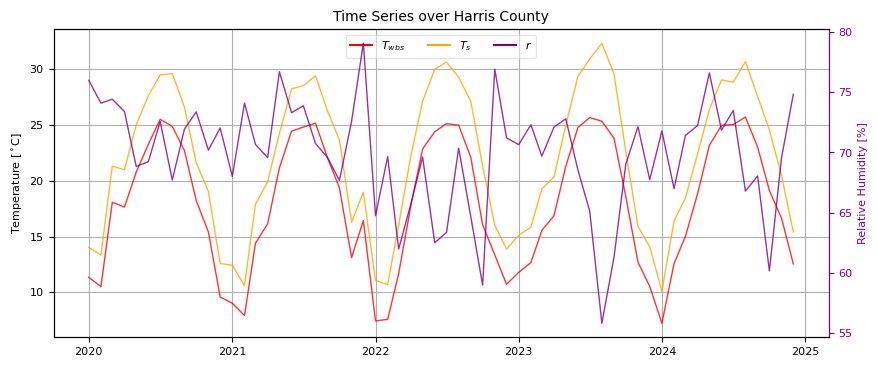

In [35]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{monthly}_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax
    # Plot only lines (removed scatter plot)
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.8, linewidth=1)

labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)

# Combine tmean, tdmean, ppt, twbs, hurs 

In [ ]:
# rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_2020.nc

In [5]:
import os
import glob 
import xarray as xr
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [6]:
import numpy as np
import os 
import xarray as xr 
import glob 
years = ['2020', '2021', '2022', '2023'] 
variables = ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean'] 
M3 = 'M3'
home = '/home/sd96/rdf'
mean_files = {}
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{M3}_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    mean_files[var] = ds_mean

    outfile = os.path.join(home, f'Harris_County_PRISM_weighted_mean_{var}_stable_4km{M3}_{years[0]}_{years[-1]}.nc')
    ds_mean.to_netcdf(outfile) 
    ds_check = xr.open_dataset(outfile)
    print(ds_check)
    print(ds_check.coords)

    print(f"Saved file for {var} at {outfile}")

<xarray.Dataset> Size: 768B
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 384B 2020-01-01 2020-02-01 ... 2023-12-01
Data variables:
    twbs     (time) float64 384B ...
Coordinates:
  * time     (time) datetime64[ns] 384B 2020-01-01 2020-02-01 ... 2023-12-01
Saved file for twbs at /home/sd96/rdf/Harris_County_PRISM_weighted_mean_twbs_stable_4kmM3_2020_2023.nc
<xarray.Dataset> Size: 768B
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 384B 2020-01-01 2020-02-01 ... 2023-12-01
Data variables:
    tmean    (time) float64 384B ...
Coordinates:
  * time     (time) datetime64[ns] 384B 2020-01-01 2020-02-01 ... 2023-12-01
Saved file for tmean at /home/sd96/rdf/Harris_County_PRISM_weighted_mean_tmean_stable_4kmM3_2020_2023.nc
<xarray.Dataset> Size: 768B
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 384B 2020-01-01 2020-02-01 ... 2023-12-01
Data variables:
    hurs     (time) float64 384B ...
Coordinates:
  * time     (

# Save as CSV

In [9]:
import xarray as xr
import os

years = ['2020', '2021', '2022', '2023'] 
variables = ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean']

datasets = []
for var in variables:
    outfile = os.path.join(
        home,
        f'Harris_County_PRISM_weighted_mean_{var}_stable_4km{M3}_{years[0]}_{years[-1]}.nc'
    )
    ds = xr.open_dataset(outfile)
    datasets.append(ds)

# Merge into one dataset
ds_combined = xr.merge(datasets)

# Convert to pandas DataFrame
df_weather_vars = ds_combined.to_dataframe().reset_index()

print(df_weather_vars.head())

outfile_csv = os.path.join(
    home,
    f"Harris_County_PRISM_{M3}_weighted_mean_weather_vars_2020_2023.csv"
)
df_weather_vars = df_weather_vars.set_index("time")
df_weather_vars.to_csv(outfile_csv)

print(f"Saved combined weather variables to {outfile_csv}")


        time       twbs      tmean       hurs         ppt     tdmean
0 2020-01-01  11.351604  14.016150  75.999225  105.136082   9.847788
1 2020-02-01  10.508931  13.340414  74.103643   46.220774   8.818845
2 2020-03-01  18.066641  21.304563  74.426334   41.857869  16.568252
3 2020-04-01  17.640930  20.992745  73.404979  104.321830  16.051460
4 2020-05-01  20.773195  25.000830  68.835025  146.588652  18.875935
Saved combined weather variables to /home/sd96/rdf/Harris_County_PRISM_M3_weighted_mean_weather_vars_2020_2023.csv


# Combine with COVID data

In [12]:
import pandas as pd
# Load and prepare COVID dataset
df_covid = pd.read_csv(
    os.path.join(home, "monthly_avg_data.csv")
)
# df_covid_full.rename(columns={'date': 'Date'}, inplace=True)
# df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])

# df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
# df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]

df_covid.set_index('Date', inplace=True)
df_covid.index = pd.to_datetime(df_covid.index)

print("COVID:", df_covid.index.min(), "to", df_covid.index.max())

# Merge COVID data with all climate variables
df_covid_weather_vars = df_weather_vars.join(df_covid, how='left')
print("df_covid_weather_vars:", df_covid_weather_vars.index.min(), "to", df_covid_weather_vars.index.max())
print(df_covid_weather_vars.columns)
df_covid_weather_vars.head(300)

outfile_csv = os.path.join(
    home,
    f"Harris_County_Monthly_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv"
)
# df_covid_weather_vars = df_covid_weather_vars.set_index("time")
df_covid_weather_vars.to_csv(outfile_csv)

print(f"Saved combined COVID and weather variables to {outfile_csv}")


COVID: 2020-07-01 00:00:00 to 2022-04-01 00:00:00
df_covid_weather_vars: 2020-01-01 00:00:00 to 2023-12-01 00:00:00
Index(['twbs', 'tmean', 'hurs', 'ppt', 'tdmean', 'Spline_PR', 'Spline_WW'], dtype='object')
Saved combined COVID and weather variables to /home/sd96/rdf/Harris_County_Monthly_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv


# Correlation Functions

In [59]:
def create_lagged_features(df, weather_vars, max_lags=6, interval_size=1, dropna=False):
    """
    Create lagged features for weather variables for each the weather vars passed
    Creates columns named as ['Precip_lag1', 'Precip_lag2', ...]
    By default, it drops the NaN values and returns a new DF

    """
    df_lagged = df.copy()


    for var in weather_vars:
        for lag in range(0, max_lags + 1):
            shift_amount = lag * interval_size
            df_lagged[f'{var}_lag{shift_amount}'] = df_lagged[var].shift(shift_amount)

    if dropna:
        df_lagged = df_lagged.dropna()
    return df_lagged

## Plot Single Corr

In [60]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import shapiro
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
def plot_lagged_correlations(df_merged, weather_variable, covid_variable,
                             interval_size, number_of_intervals, time_unit="Months",
                             # lags={"0 days": 0, "7 days": 7, "14 days": 14, "21 days": 21, "28 days": 28, "35 days": 35},
                             file_name_suffix = '', wwtp_plant_and_station_name='', save_path='plots'):

    stat, p = shapiro(df_merged[weather_variable]) 
    print('Shapiro-Wilk p-value:', p)
    lags = {}
    for i in range(0, number_of_intervals + 1): 
        lags[f'{i * interval_size} {time_unit}'] = i * interval_size

    print(lags)

    df_merged = create_lagged_features(df_merged, [weather_variable], max_lags=number_of_intervals, interval_size=interval_size) 

    print("df_merged", df_merged.index.min(), "to", df_merged.index.max())
    # print(df_merged.columns)

    correlations = {}
    p_values = {}
    
    for lag in lags.values():

        lagged_col = f"{weather_variable}_lag{lag}"

        temp = df_merged[[covid_variable, lagged_col]].dropna()
            
        corr, p = spearmanr(temp[covid_variable], temp[lagged_col])
    
        correlations[lag] = corr
        p_values[lag] = p

    x = list(lags.values())
    y = [correlations[lag] for lag in x]

    # plot correlations
    num_lags = len(lags)
    fig_width = max(8, num_lags * 0.5)
    plt.figure(figsize=(fig_width, 5))
    plt.plot(x, y, marker='o', label=covid_variable)

    # add annotations to each point with p values
    for i, lag in enumerate(lags.values()):
        r = correlations[lag]
        p = p_values[lag]
    
        color = "green" if p < 0.05 else "black"  
        plt.annotate(f"{r:.3f}", (lag, r), textcoords="offset points", xytext=(4, -12), ha='left', fontsize=8, color=color)        
    
    plt.xlabel(f"lag ({time_unit})")
    plt.xticks(list(lags.values()))
    plt.ylabel("Correlation")
    plt.title(f"Lag Correlations of {weather_variable} vs {covid_variable} {file_name_suffix}")
    plt.legend()
    plt.grid(True)

    # Print results 
    # for lag in lags.values():
    #     print(f"Lag {lag} {time_unit}:")
    #     print(f"  {covid_variable}: r = {correlations[lag]:.3f}, p = {p_values[lag]:.3f}")

    filename = ''
    time_span = "Monthly" if time_unit == "Months" else "Daily"
    if file_name_suffix: 
        filename = os.path.join(save_path, f"{time_span}_{weather_variable}_{covid_variable}_Lagged_Correlation_{file_name_suffix}.png")
    else:
        filename = os.path.join(save_path, f"{time_span}_{weather_variable}_{covid_variable}_Lagged_Correlation.png")

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Plot saved: {filename}")
    plt.show()
    
    # Save top lags for wastewater
    top_lags = [lag for lag, r in correlations.items() if abs(r) > 0.3]

    print("Top lags:", top_lags)
    
    cols = [covid_variable] + [f"{weather_variable}_lag{lag}" for lag in top_lags]

    return df_merged


## Plot all

In [40]:
import matplotlib.colors as mcolors

def darken(color, amount=0.6):
    """Darken a given matplotlib color by multiplying RGB by amount."""
    c = mcolors.to_rgb(color)
    return (c[0]*amount, c[1]*amount, c[2]*amount)


In [65]:
def plot_lagged_correlations_multi(df_merged, weather_variables, covid_variable,
                                   interval_size, number_of_intervals, time_unit="Months",
                                   file_name_suffix='', save_path='plots'):

    TITLE_LABELS = {'ppt': 'Precipitation', 
                    'tmean': 'Temperature', 
                    'twbs': 'Wet Bulb Temperature', 
                   'hurs': 'Relative Humidity', 
                   'Spline_WW': 'Viral Load', 
                   'Spline_PR': 'Positivity Rate'}
    
    FIG_LABELS = {'ppt': r'$P$', 
                  'tmean': r'$T_{s}$', 
                  'twbs': r'$T_{wbs}$',
                 'hurs': r'$r$'}

    # define lags
    lags = {f'{i * interval_size} {time_unit}': i * interval_size
            for i in range(0, number_of_intervals + 1)}

    # create lagged features for all weather variables
    df_merged = create_lagged_features(df_merged, weather_variables,
                                       max_lags=number_of_intervals,
                                       interval_size=interval_size) 

    print("df_merged", df_merged.index.min(), "to", df_merged.index.max())

    # setup plot
    num_lags = len(lags)
    fig_width = max(8, num_lags * 0.5)
    plt.figure(figsize=(fig_width, 5))

    # loop through weather variables
    for weather_variable in weather_variables:
        correlations = {}
        p_values = {}

        for lag in lags.values():
            lagged_col = f"{weather_variable}_lag{lag}"
            temp = df_merged[[covid_variable, lagged_col]].dropna()
            corr, p = spearmanr(temp[covid_variable], temp[lagged_col])
            correlations[lag] = corr
            p_values[lag] = p

        x = list(lags.values())
        y = [correlations[lag] for lag in x]

        # use FIG_LABELS for legend label
        label = FIG_LABELS.get(weather_variable, weather_variable)

         # pick a base line color automatically
        # plot line
        line, = plt.plot(x, y, label=label)  
        base_color = line.get_color()
        
        # black if significant, else same as line color
        colors = ['black' if p_values[lag] < 0.05 else base_color for lag in lags.values()]
        
        # scatter markers
        plt.scatter(x, y, c=colors, edgecolor=base_color, zorder=2)



    # finalize plot
    plt.xlabel(f"Lag ({time_unit})")
    plt.xticks(list(lags.values()))
    plt.ylabel("Spearman Correlation")

    time_span = "Monthly" if time_unit == "Months" else "Daily"
    # use TITLE_LABELS if only one weather variable, otherwise generic
    if len(weather_variables) == 1:
        wvar = weather_variables[0]
        title_var = TITLE_LABELS.get(wvar, wvar)
        plt.title(f"{time_span} Lag Correlations for {title_var} vs {TITLE_LABELS[covid_variable]} {file_name_suffix}")
    else:
        plt.title(f"{time_span} Lag Correlations for Weather Variables vs {TITLE_LABELS[covid_variable]} {file_name_suffix}")

    plt.legend()
    plt.grid(True)

    # save
    if file_name_suffix: 
        filename = os.path.join(save_path, f"{time_span}_AllWeather_{covid_variable}_Lagged_Correlation_{file_name_suffix}.pdf")
    else:
        filename = os.path.join(save_path, f"{time_span}_AllWeather_{covid_variable}_Lagged_Correlation.pdf")

    plt.savefig(filename, dpi=300, bbox_inches="tight", )
    print(f"Plot saved: {filename}")
    plt.show()

    return df_merged


# Load Monthly CSV with Differenced Columns

In [55]:
MONTHLY_PATH = "Harris_County_Monthly_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv"
FINAL_PLOTS = "final_plots"
TMEAN = "tmean"
PPT = "ppt"
TDMEAN = "tdmean"
HURS = "hurs"
TWBS = "twbs"
SPLINE_WW = "Spline_WW"
SPLINE_PR = "Spline_PR"
MONTHLY = "monthly"
# SPLINE_WW_COLS = ["Spline_WW

TITLE_LABELS = {'ppt': 'Precipitation', 'tmean': 'Temperature', 'twbs': 'Wet Bulb Temperature'}
FIG_LABELS = {'ppt': r'$P$', 'tmean': r'$T_(s)$', 'twbs': r'$T_(wbs)$'}

# 'time', 'twbs', 'tmean', 'hurs', 'ppt', 'tdmean', 'Spline_PR',
DF_MONTHLY_COLS =  ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean', 'Spline_PR',
       'Spline_WW', 'tmean differenced', 'twbs differenced',
       'Spline_WW differenced', 'Spline_WW differenced twice',
       'Spline_PR differenced', 'Spline_PR differenced twice']

In [62]:
df_monthly_covid_weather = pd.read_csv(
    os.path.join(MONTHLY_PATH),
    index_col=0,      
    parse_dates=True
)

df_monthly_covid_weather.head(300)


/tmp/ipykernel_9699/1985563144.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_monthly_covid_weather = pd.read_csv(


,time,twbs,tmean,hurs,ppt,tdmean,Spline_PR,Spline_WW,tmean differenced,twbs differenced,Spline_WW differenced,Spline_WW differenced twice,Spline_PR differenced,Spline_PR differenced twice
0,2020-01-01,11.351604,14.016150,75.999225,105.136082,9.847788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,10.508931,13.340414,74.103643,46.220774,8.818845,NaN,NaN,-0.675736,-0.842673,NaN,NaN,NaN,NaN
2,2020-03-01,18.066641,21.304563,74.426334,41.857869,16.568252,NaN,NaN,7.964149,7.557710,NaN,NaN,NaN,NaN
3,2020-04-01,17.640930,20.992745,73.404979,104.321830,16.051460,NaN,NaN,-0.311818,-0.425710,NaN,NaN,NaN,NaN
4,2020-05-01,20.773195,25.000830,68.835025,146.588652,18.875935,NaN,NaN,4.008085,3.132264,NaN,NaN,NaN,NaN
5,2020-06-01,23.274240,27.631965,69.232590,170.932935,21.482585,NaN,NaN,2.631136,2.501046,NaN,NaN,NaN,NaN
6,2020-07-01,25.504547,29.476785,72.582681,136.406856,24.028484,0.242224,13.326941,1.844820,2.230306,NaN,NaN,NaN,NaN
7,2020-08-01,24.863915,29.599364,67.708668,79.098782,22.991535,0.145059,12.846436,0.122579,-0.640632,-0.480505,NaN,-0.097165,NaN
8,2020-09-01,22.702721,26.591812,71.949317,251.840201,21.114739,0.075531,12.986499,-3.007552,-2.161194,0.140063,0.620567,-0.069528,0.027636
9,2020-10-01,18.215216,21.605493,73.378746,37.868303,16.636462,0.063678,13.280605,-4.986319,-4.487505,0.294106,0.154043,-0.011853,0.057675


# Correlation Analysis

## All Variables (Tmean, Twbs, Ppt)

df_merged 0 to 47
Plot saved: final_plots/Monthly_AllWeather_Spline_WW_Lagged_Correlation.pdf


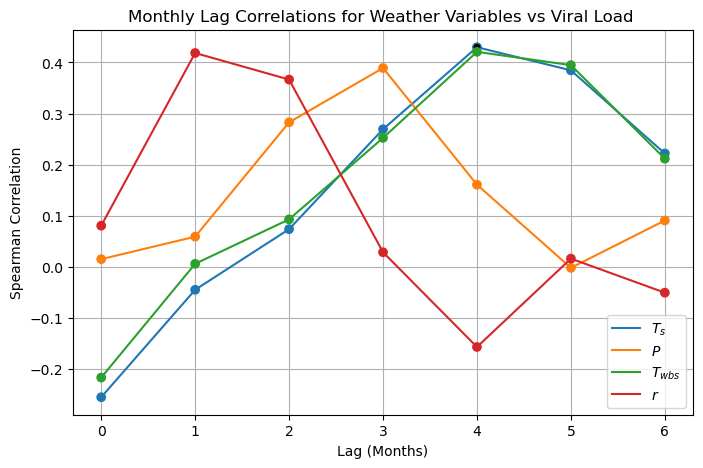

,time,twbs,tmean,hurs,ppt,tdmean,Spline_PR,Spline_WW,tmean differenced,twbs differenced,...,twbs_lag4,twbs_lag5,twbs_lag6,hurs_lag0,hurs_lag1,hurs_lag2,hurs_lag3,hurs_lag4,hurs_lag5,hurs_lag6
0,2020-01-01,11.351604,14.016150,75.999225,105.136082,9.847788,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.999225,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,10.508931,13.340414,74.103643,46.220774,8.818845,NaN,NaN,-0.675736,-0.842673,...,NaN,NaN,NaN,74.103643,75.999225,NaN,NaN,NaN,NaN,NaN
2,2020-03-01,18.066641,21.304563,74.426334,41.857869,16.568252,NaN,NaN,7.964149,7.557710,...,NaN,NaN,NaN,74.426334,74.103643,75.999225,NaN,NaN,NaN,NaN
3,2020-04-01,17.640930,20.992745,73.404979,104.321830,16.051460,NaN,NaN,-0.311818,-0.425710,...,NaN,NaN,NaN,73.404979,74.426334,74.103643,75.999225,NaN,NaN,NaN
4,2020-05-01,20.773195,25.000830,68.835025,146.588652,18.875935,NaN,NaN,4.008085,3.132264,...,11.351604,NaN,NaN,68.835025,73.404979,74.426334,74.103643,75.999225,NaN,NaN
5,2020-06-01,23.274240,27.631965,69.232590,170.932935,21.482585,NaN,NaN,2.631136,2.501046,...,10.508931,11.351604,NaN,69.232590,68.835025,73.404979,74.426334,74.103643,75.999225,NaN
6,2020-07-01,25.504547,29.476785,72.582681,136.406856,24.028484,0.242224,13.326941,1.844820,2.230306,...,18.066641,10.508931,11.351604,72.582681,69.232590,68.835025,73.404979,74.426334,74.103643,75.999225
7,2020-08-01,24.863915,29.599364,67.708668,79.098782,22.991535,0.145059,12.846436,0.122579,-0.640632,...,17.640930,18.066641,10.508931,67.708668,72.582681,69.232590,68.835025,73.404979,74.426334,74.103643
8,2020-09-01,22.702721,26.591812,71.949317,251.840201,21.114739,0.075531,12.986499,-3.007552,-2.161194,...,20.773195,17.640930,18.066641,71.949317,67.708668,72.582681,69.232590,68.835025,73.404979,74.426334
9,2020-10-01,18.215216,21.605493,73.378746,37.868303,16.636462,0.063678,13.280605,-4.986319,-4.487505,...,23.274240,20.773195,17.640930,73.378746,71.949317,67.708668,72.582681,69.232590,68.835025,73.404979


In [67]:
weather_vars = [TMEAN, PPT, TWBS, HURS]
covid_var = SPLINE_WW

plot_lagged_correlations_multi(df_monthly_covid_weather,
                               weather_vars,
                               covid_var,
                               interval_size=1,
                               number_of_intervals=6,
                               save_path=os.path.join(FINAL_PLOTS))


## Twbs

### Twbs & Spline_WW

Cols Spline_WW, twbs
Shapiro-Wilk p-value: 0.0039084552689450935
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs_Spline_WW_Lagged_Correlation.png


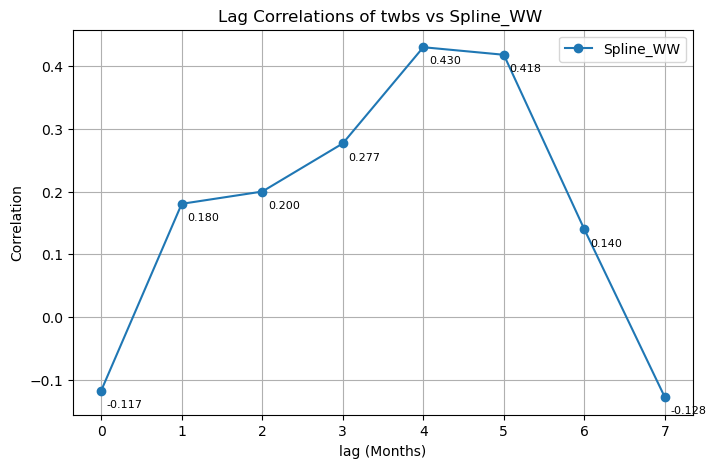

Top lags: [4, 5]
Cols Spline_WW, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_WW_Lagged_Correlation.png


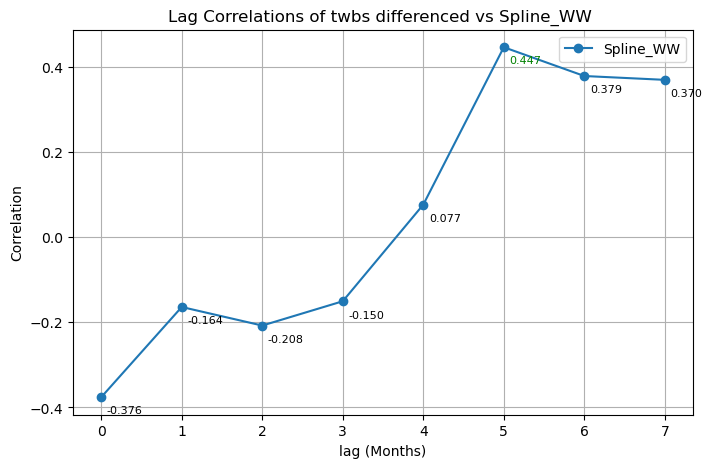

Top lags: [0, 5, 6, 7]
Cols Spline_WW differenced, twbs
Shapiro-Wilk p-value: 0.0039084552689450935
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs_Spline_WW differenced_Lagged_Correlation.png


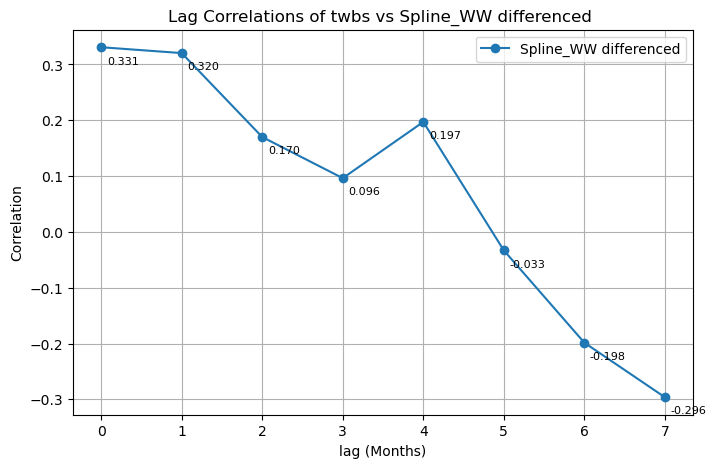

Top lags: [0, 1]
Cols Spline_WW differenced, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_WW differenced_Lagged_Correlation.png


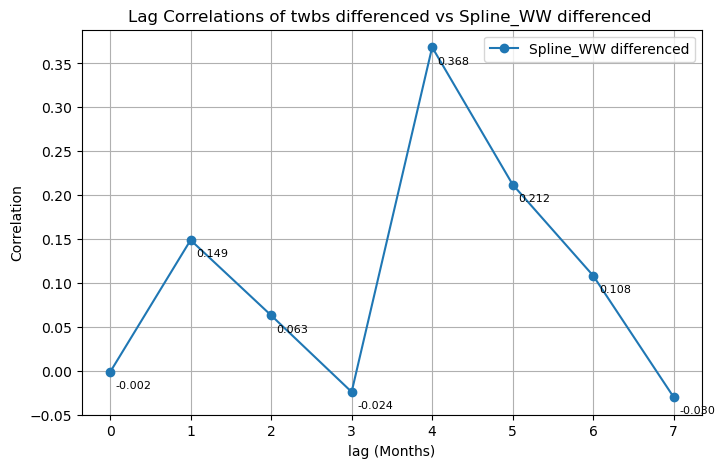

Top lags: [4]
Cols Spline_WW differenced twice, twbs
Shapiro-Wilk p-value: 0.0039084552689450935
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs_Spline_WW differenced twice_Lagged_Correlation.png


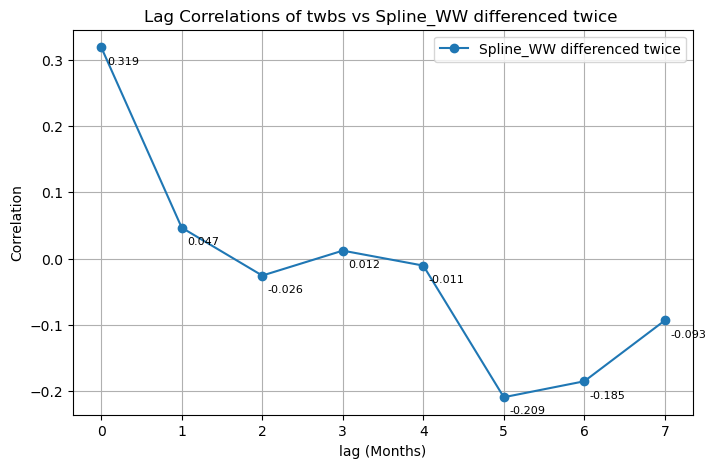

Top lags: [0]
Cols Spline_WW differenced twice, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_WW differenced twice_Lagged_Correlation.png


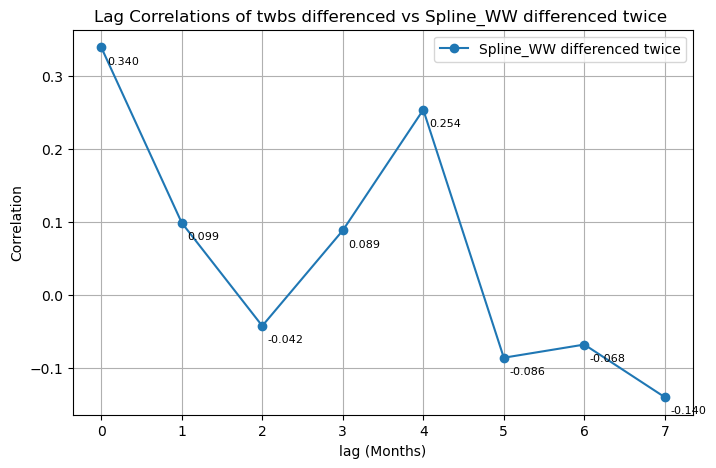

Top lags: [0]


In [69]:
covid_var = SPLINE_WW
weather_var = TWBS
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))

### Twbs & Spline_PR

Cols Spline_PR, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR_Lagged_Correlation.png


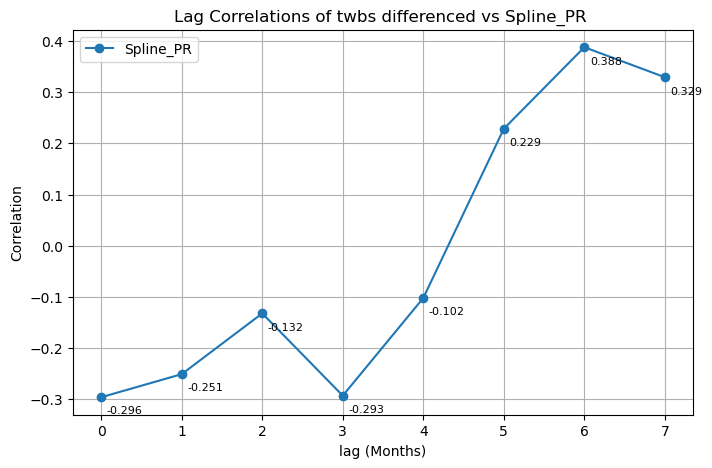

Top lags: [6, 7]
Cols Spline_PR, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR_Lagged_Correlation.png


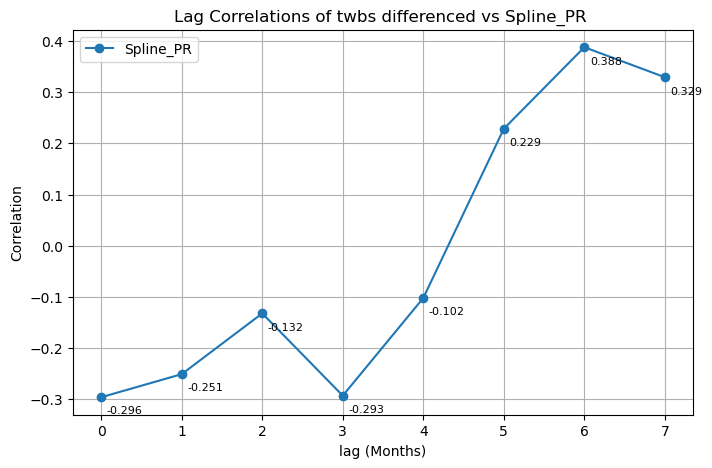

Top lags: [6, 7]
Cols Spline_PR differenced, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR differenced_Lagged_Correlation.png


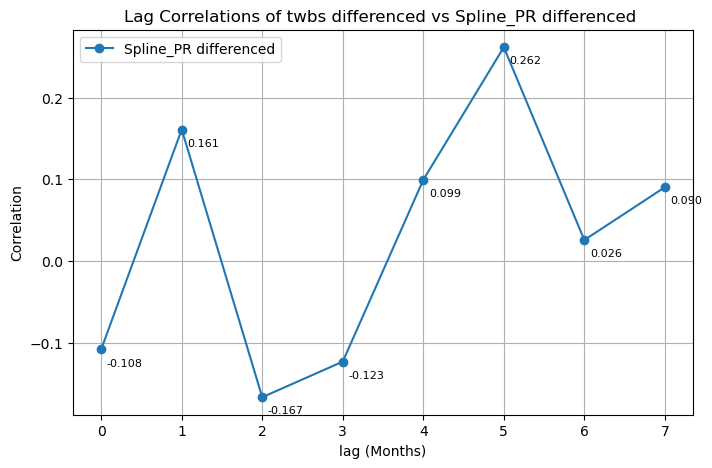

Top lags: []
Cols Spline_PR differenced, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR differenced_Lagged_Correlation.png


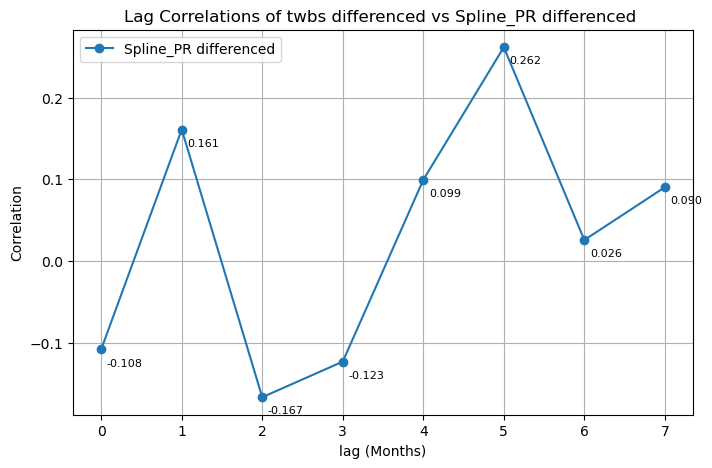

Top lags: []
Cols Spline_PR differenced twice, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR differenced twice_Lagged_Correlation.png


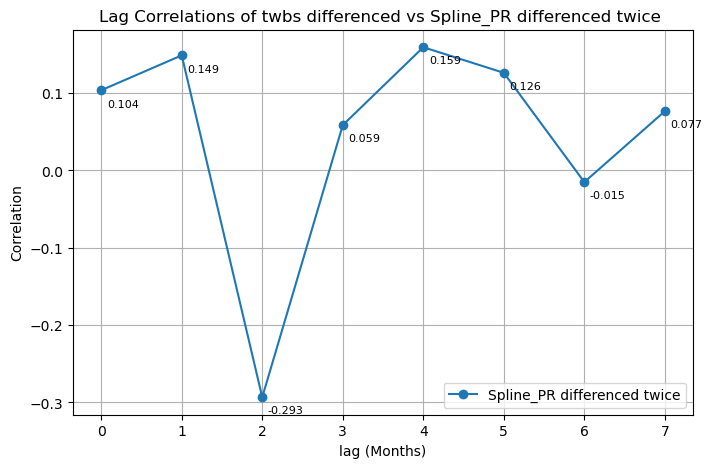

Top lags: []
Cols Spline_PR differenced twice, twbs differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/twbs/monthly/Monthly_twbs differenced_Spline_PR differenced twice_Lagged_Correlation.png


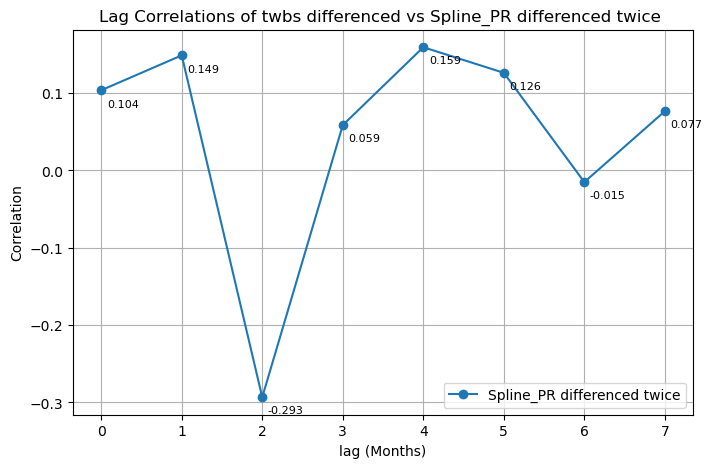

Top lags: []


In [70]:
covid_var = SPLINE_PR
weather_var = TWBS
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weathber_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))

## Tmean

### Tmean & Spline_WW 

Cols Spline_WW, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_WW_Lagged_Correlation.png


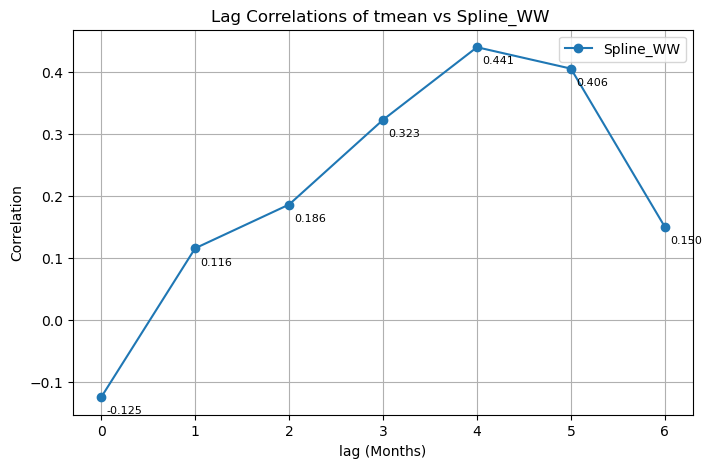

Top lags: [3, 4, 5]
Cols Spline_WW, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_WW_Lagged_Correlation.png


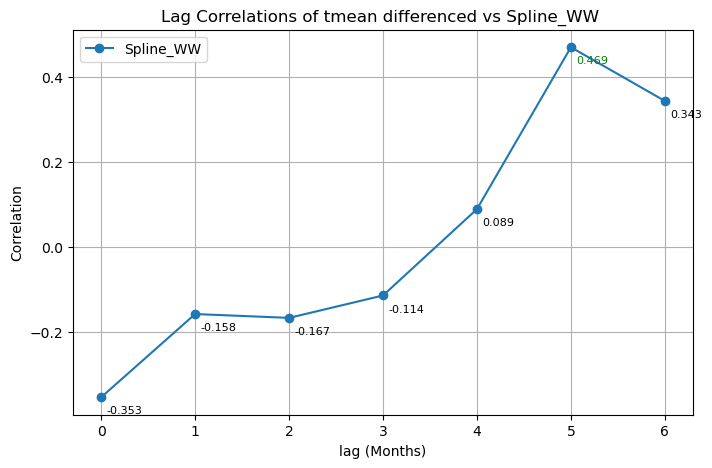

Top lags: [0, 5, 6]
Cols Spline_WW differenced, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_WW differenced_Lagged_Correlation.png


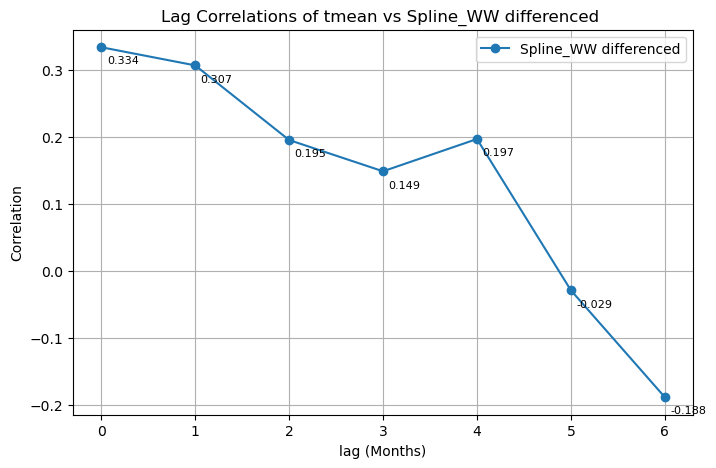

Top lags: [0, 1]
Cols Spline_WW differenced, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_WW differenced_Lagged_Correlation.png


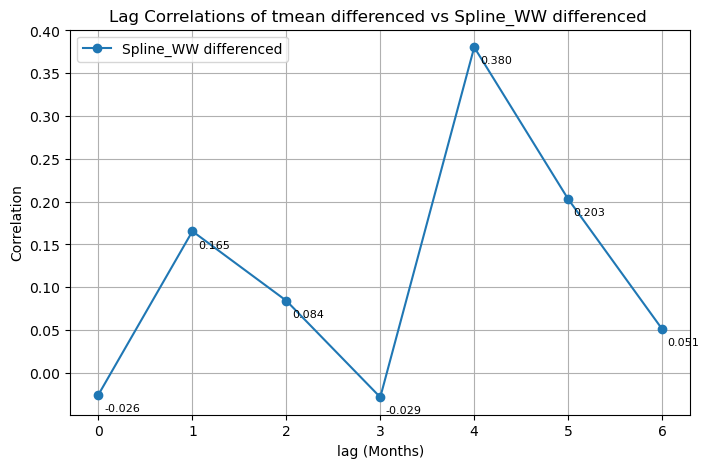

Top lags: [4]
Cols Spline_WW differenced twice, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_WW differenced twice_Lagged_Correlation.png


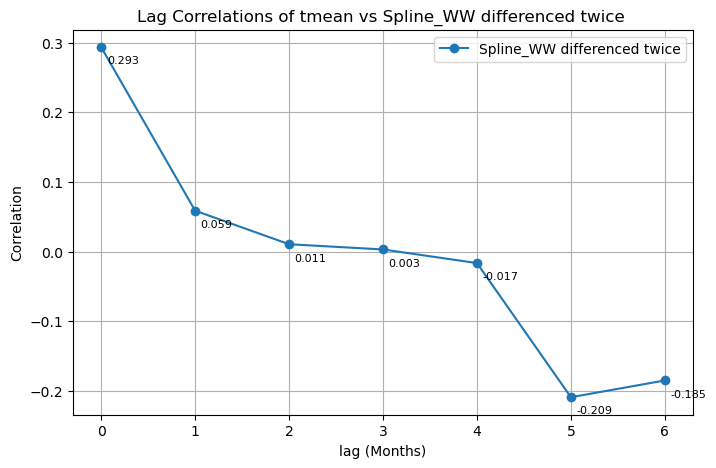

Top lags: []
Cols Spline_WW differenced twice, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_WW differenced twice_Lagged_Correlation.png


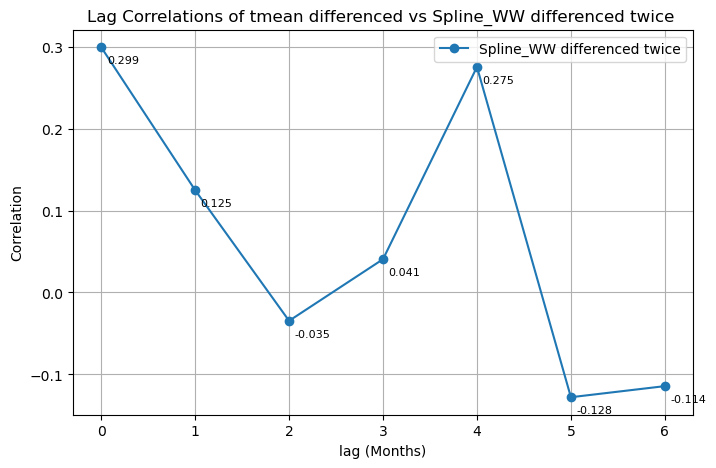

Top lags: []


In [76]:
covid_var = SPLINE_WW
weather_var = TMEAN
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=6, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))

Cols Spline_PR, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_PR_Lagged_Correlation.png


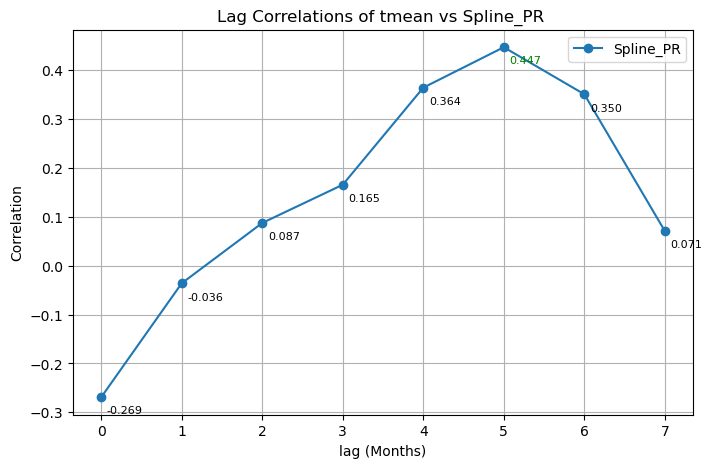

Top lags: [4, 5, 6]
Cols Spline_PR, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_PR_Lagged_Correlation.png


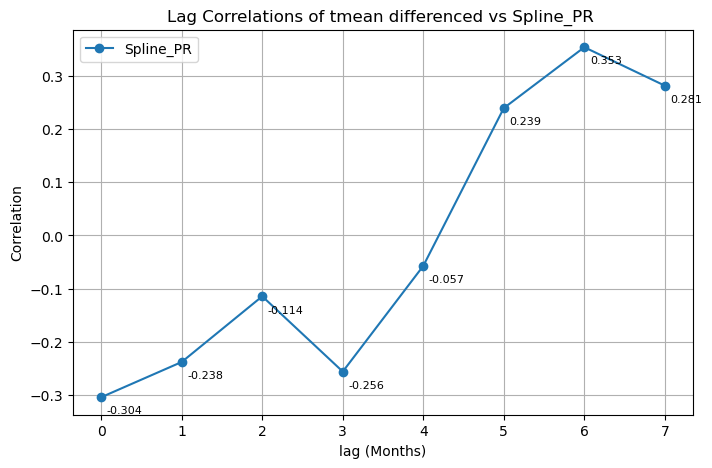

Top lags: [0, 6]
Cols Spline_PR differenced, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_PR differenced_Lagged_Correlation.png


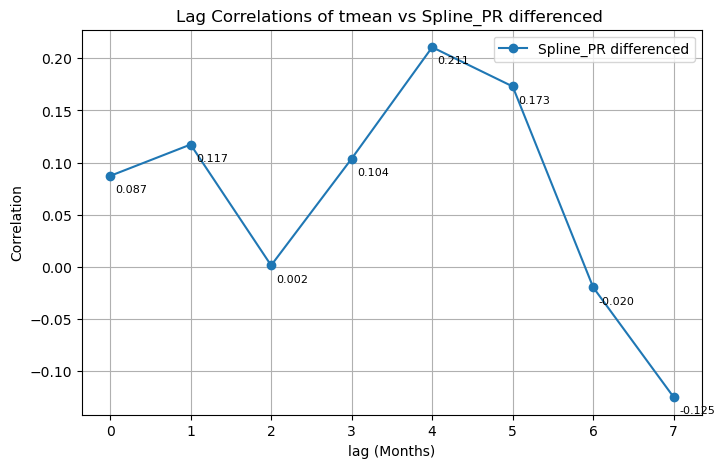

Top lags: []
Cols Spline_PR differenced, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_PR differenced_Lagged_Correlation.png


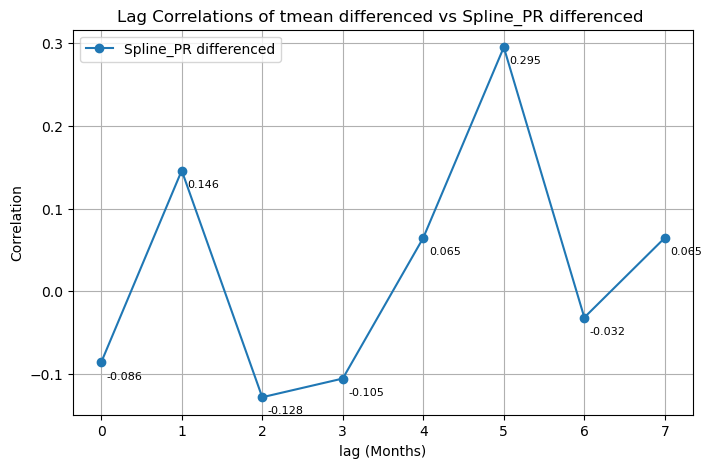

Top lags: []
Cols Spline_PR differenced twice, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean_Spline_PR differenced twice_Lagged_Correlation.png


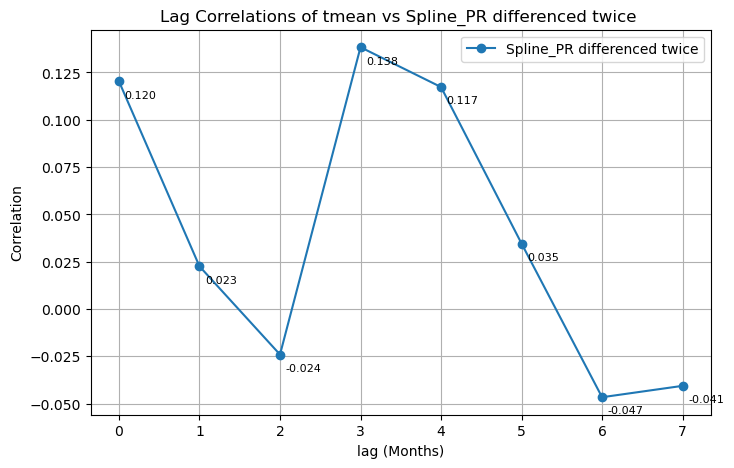

Top lags: []
Cols Spline_PR differenced twice, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/monthly/Monthly_tmean differenced_Spline_PR differenced twice_Lagged_Correlation.png


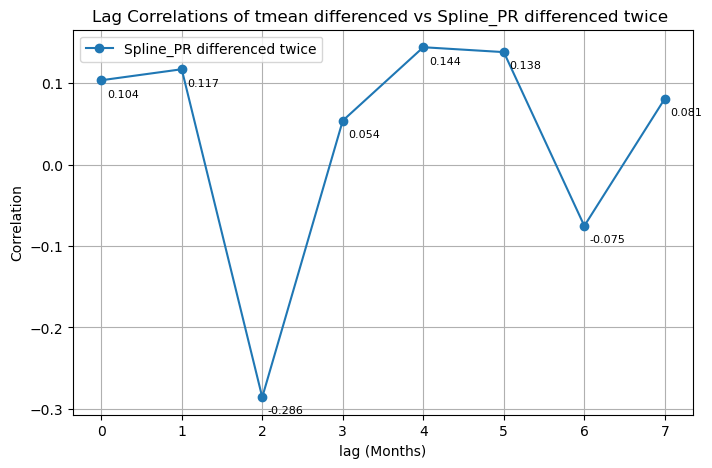

Top lags: []


In [72]:
covid_var = SPLINE_PR
weather_var = TMEAN
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))

### Tmean & Spline_PR

Cols Spline_PR, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean_Spline_PR_Lagged_Correlation.png


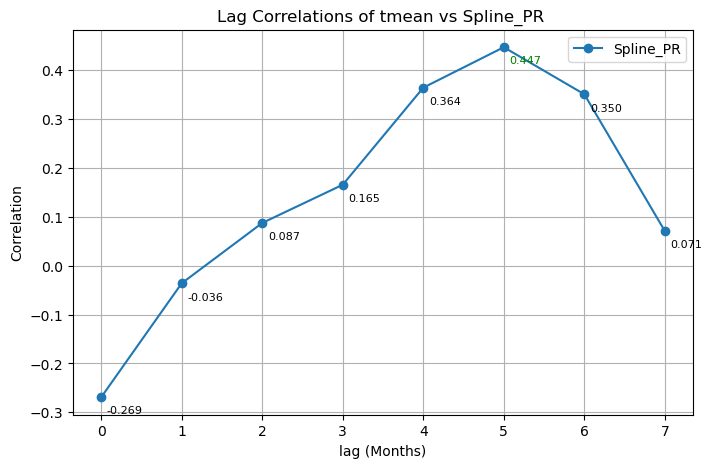

Top lags: [4, 5, 6]
Cols Spline_PR, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean differenced_Spline_PR_Lagged_Correlation.png


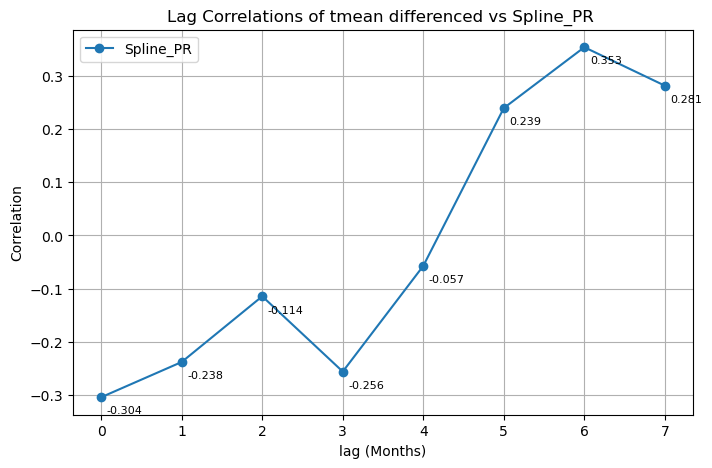

Top lags: [0, 6]
Cols Spline_PR differenced, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean_Spline_PR differenced_Lagged_Correlation.png


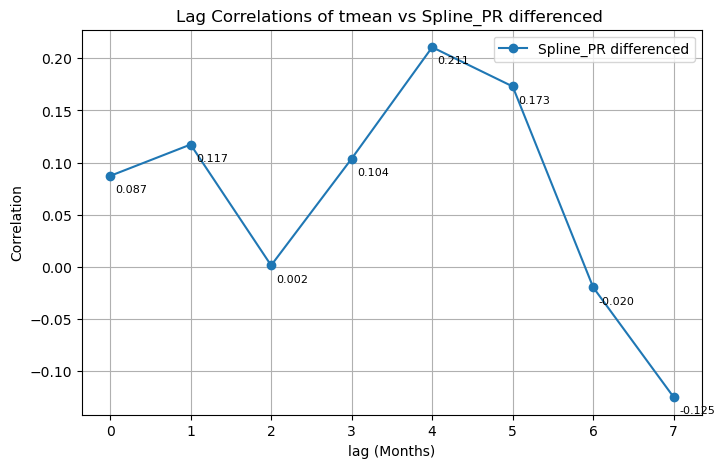

Top lags: []
Cols Spline_PR differenced, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean differenced_Spline_PR differenced_Lagged_Correlation.png


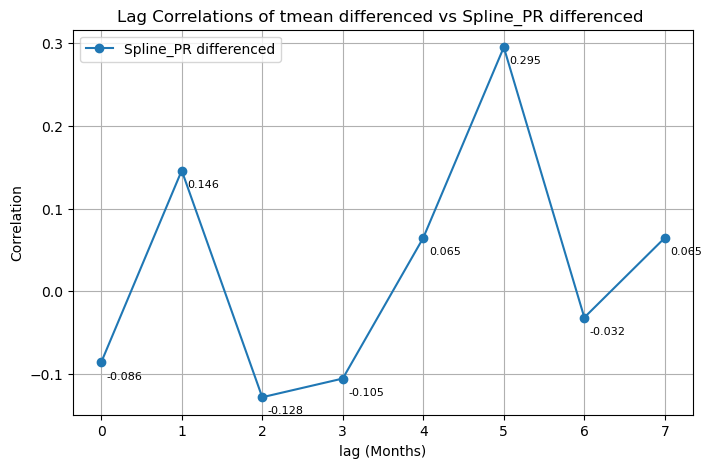

Top lags: []
Cols Spline_PR differenced twice, tmean
Shapiro-Wilk p-value: 0.015143611110000415
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean_Spline_PR differenced twice_Lagged_Correlation.png


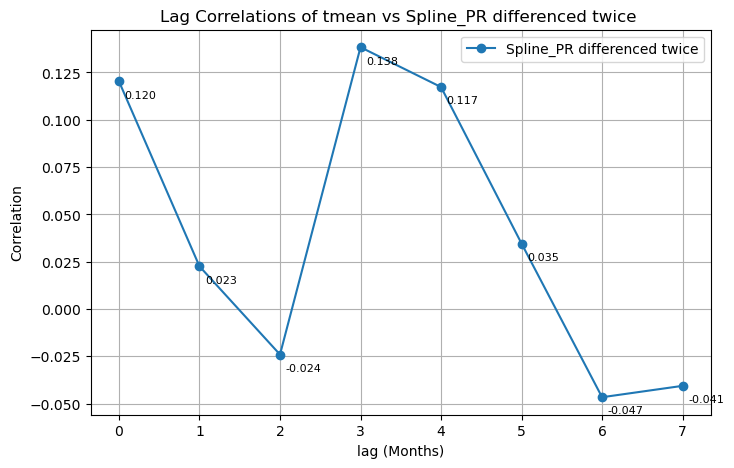

Top lags: []
Cols Spline_PR differenced twice, tmean differenced
Shapiro-Wilk p-value: nan
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/tmean/Monthly_tmean differenced_Spline_PR differenced twice_Lagged_Correlation.png


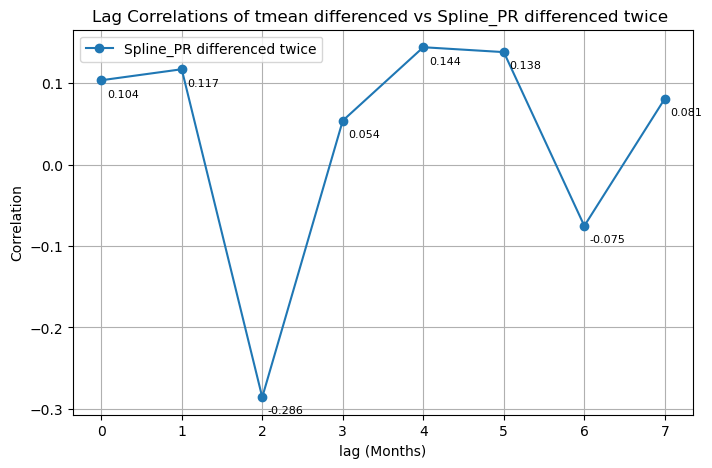

Top lags: []


In [73]:
covid_var = SPLINE_PR
weather_var = TMEAN
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var))

## Ppt 

### Ppt & Spline_WW

Cols Spline_WW, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_WW_Lagged_Correlation.png


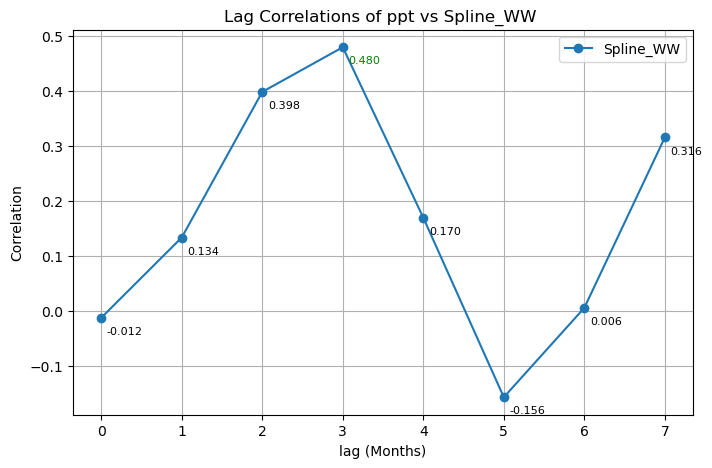

Top lags: [2, 3, 7]
Cols Spline_WW differenced, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_WW differenced_Lagged_Correlation.png


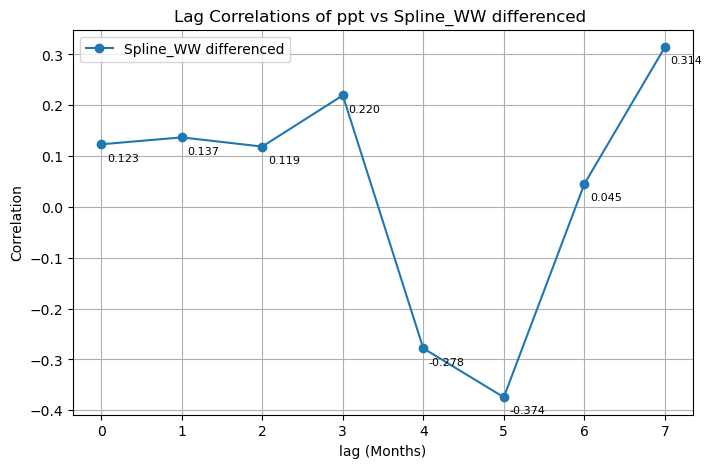

Top lags: [5, 7]
Cols Spline_WW differenced twice, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_WW differenced twice_Lagged_Correlation.png


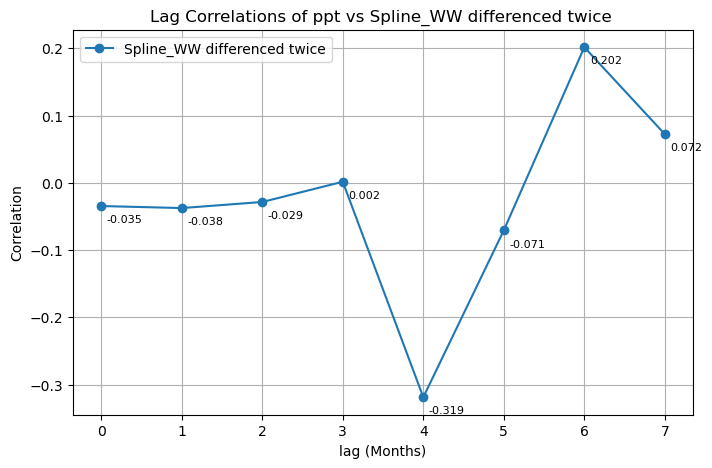

Top lags: [4]


In [74]:
covid_var = SPLINE_WW
weather_var = PPT
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))

### Ppt & Spline_PR

Cols Spline_PR, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_PR_Lagged_Correlation.png


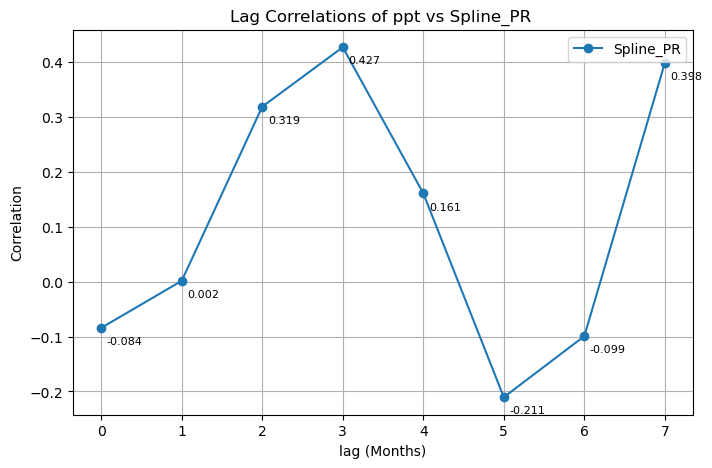

Top lags: [2, 3, 7]
Cols Spline_PR differenced, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_PR differenced_Lagged_Correlation.png


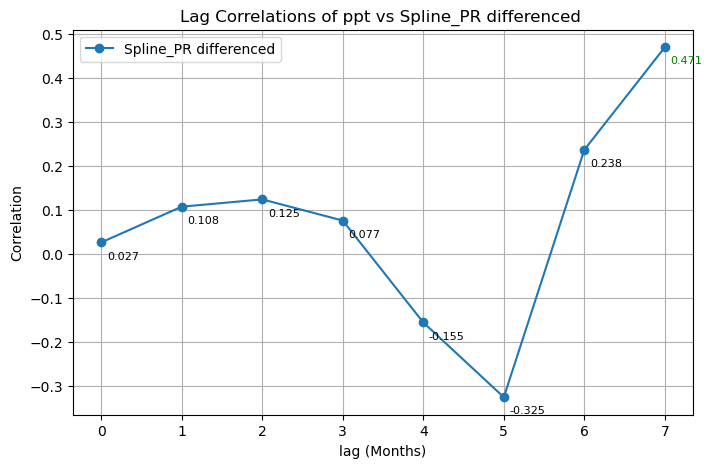

Top lags: [5, 7]
Cols Spline_PR differenced twice, ppt
Shapiro-Wilk p-value: 0.0014168922876824173
{'0 Months': 0, '1 Months': 1, '2 Months': 2, '3 Months': 3, '4 Months': 4, '5 Months': 5, '6 Months': 6, '7 Months': 7}
df_merged 8 to 27
Plot saved: final_plots/ppt/monthly/Monthly_ppt_Spline_PR differenced twice_Lagged_Correlation.png


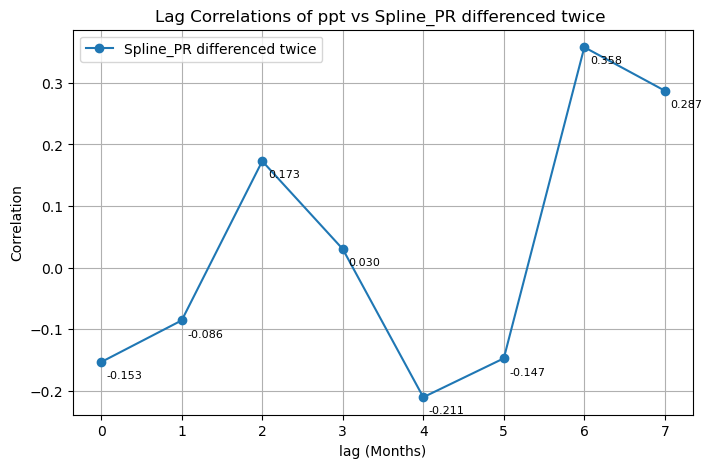

Top lags: [6]


In [75]:
covid_var = SPLINE_PR
weather_var = PPT
for covid_col in [col for col in DF_MONTHLY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_MONTHLY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_monthly_covid_weather, weather_col, covid_col, interval_size=1, number_of_intervals=7, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, MONTHLY))